In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt -O /tmp/sonnets.txt

--2020-08-06 08:53:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.128, 173.194.197.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-08-06 08:53:29 (102 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
tokenizer = Tokenizer()

data = open('/tmp/sonnets.txt').read()
corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'and': 1, 'the': 2, 'to': 3, 'of': 4, 'my': 5, 'i': 6, 'in': 7, 'that': 8, 'thy': 9, 'thou': 10, 'with': 11, 'for': 12, 'is': 13, 'love': 14, 'not': 15, 'but': 16, 'a': 17, 'me': 18, 'thee': 19, 'so': 20, 'be': 21, 'as': 22, 'all': 23, 'you': 24, 'his': 25, 'which': 26, 'when': 27, 'it': 28, 'this': 29, 'by': 30, 'your': 31, 'doth': 32, 'do': 33, 'from': 34, 'on': 35, 'or': 36, 'no': 37, 'then': 38, 'have': 39, 'what': 40, 'are': 41, 'if': 42, 'more': 43, 'mine': 44, 'their': 45, 'shall': 46, 'sweet': 47, 'time': 48, 'will': 49, 'they': 50, 'beauty': 51, 'nor': 52, 'eyes': 53, 'art': 54, 'her': 55, 'heart': 56, 'yet': 57, 'o': 58, 'than': 59, 'can': 60, 'should': 61, 'thine': 62, 'now': 63, 'where': 64, 'make': 65, 'one': 66, 'hath': 67, 'he': 68, 'fair': 69, 'still': 70, 'how': 71, 'eye': 72, 'him': 73, 'like': 74, 'true': 75, 'see': 76, 'am': 77, 'she': 78, 'those': 79, 'though': 80, 'being': 81, 'some': 82, 'every': 83, 'such': 84, 'own': 85, 'were': 86, 'dost': 87, 'who': 88, 'liv

In [4]:
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

predictors, labels = input_sequences[:,:-1], input_sequences[:,-1]
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [12]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(predictors, labels, epochs=200, verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 10, 256)           234496    
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                82176     
_________________________________________________________________
dense_10 (Dense)             (None, 1605)              104325    
_________________________________________________________________
dense_11 (Dense)             (None, 3211)              5156866   
Total params: 5,898,963
Trainable params: 5,898,963
Non-trainable params: 0
____________________________________________

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.show()

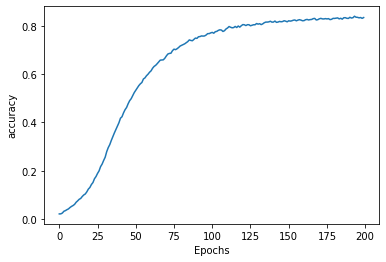

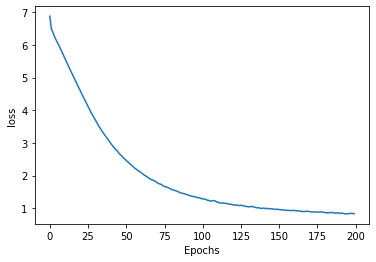

In [14]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [15]:
seed_text = "Catch me outside, how about that"
next_words = 100

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Catch me outside, how about that am earth or nature's frame place something more eyes confounds well had bright doth wretched allow taken sit wit worth dead new chary slain green thee some dearer book live new hence slain ' rare rare rare behind thine eyes hath mine eyes lies famish'd that be die you confounds forth forth ride thee confounds you change bright bring forth strife hence stay assured women's woe moan new control control new spirit age or true age alone by did say both wide worth rare but kind new up thee alone shows thee now often ' lies forsworn die control thee
